In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import random as random 
import math

Import data

In [2]:
df = pd.read_csv("df2.csv")

In [3]:
df.shape

(589, 17)

In [4]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,age,LoanAmountScale,TotalIncome,MonthlyPayment,DebtToIncomeRatio,TotalIncomeCut
0,Male,No,0,Graduate,No,5849,0.0,360.0,1.0,Urban,Y,45.0,128000.0,5849.0,355.555556,0.060789,2nd part
1,Male,Yes,1,Graduate,No,4583,1508.0,360.0,1.0,Rural,N,48.0,128000.0,6091.0,355.555556,0.058374,2nd part
2,Male,Yes,0,Graduate,Yes,3000,0.0,360.0,1.0,Urban,Y,34.0,66000.0,3000.0,183.333333,0.061111,1st part
3,Male,Yes,0,Not Graduate,No,2583,2358.0,360.0,1.0,Urban,Y,34.0,120000.0,4941.0,333.333333,0.067463,1st part
4,Male,No,0,Graduate,No,6000,0.0,360.0,1.0,Urban,Y,38.0,141000.0,6000.0,391.666667,0.065278,2nd part


# KPI

#### Socio-Demographic

In [5]:
variables = ["Gender", "Education", "Married"]
results = []

for var in variables:
    contingency = pd.crosstab(df[var], df["Loan_Status"])
    chi2, p, dof, _ = stats.chi2_contingency(contingency)
    results.append({
        "Variable": var,
        "Chi2 Statistic": chi2,
        "Degrees of Freedom": dof,
        "p-value": p
    })

df_results = pd.DataFrame(results)
df_results["Interpretation"] = df_results["p-value"].apply(
    lambda p: "Significant (p < 0.05)" if p < 0.05 else "Not significant"
)


df_results_display = df_results.copy()
df_results_display["Chi2 Statistic"] = df_results_display["Chi2 Statistic"].round(3)
df_results_display["p-value"] = df_results_display["p-value"].apply(lambda x: f"{x:.4f}")

print("\n=== Chi-square Test Results ===\n")
print(df_results_display.to_string(index=False))




=== Chi-square Test Results ===

  Variable  Chi2 Statistic  Degrees of Freedom p-value          Interpretation
    Gender           0.174                   1  0.6762         Not significant
 Education           4.610                   1  0.0318  Significant (p < 0.05)
   Married           4.907                   1  0.0268  Significant (p < 0.05)


In [6]:
group_accepted = df[df["Loan_Status"] == "Y"]["age"]
group_refused = df[df["Loan_Status"] == "N"]["age"]

t_stat, p_val = stats.ttest_ind(group_accepted, group_refused, equal_var=False) 

print(f"T-test statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Result: Significant difference in mean age between loan status groups.")
else:
    print("Result: No significant difference in mean age between loan status groups.")


T-test statistic: -2.868
P-value: 0.0045
Result: Significant difference in mean age between loan status groups.


#### Financial

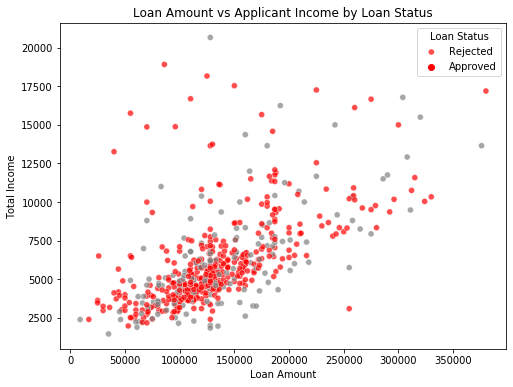

In [7]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='LoanAmountScale', y='TotalIncome', 
                hue='Loan_Status', 
                palette={'Y': 'red', 'N': 'gray'},
                alpha=0.7)

plt.xlabel("Loan Amount")
plt.ylabel("Total Income")
plt.title("Loan Amount vs Applicant Income by Loan Status")

plt.legend(title='Loan Status', labels=['Rejected', 'Approved'])

plt.show()


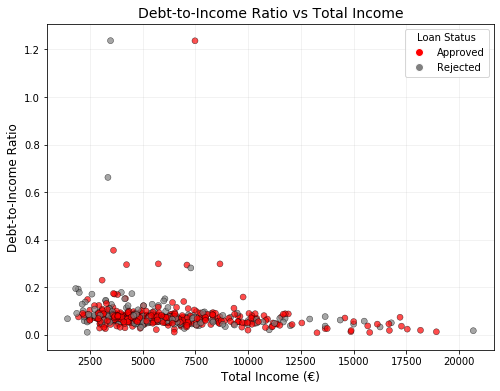

In [8]:


palette = {'Y': 'red', 'N': 'gray'}

plt.figure(figsize=(8, 6))

sns.scatterplot(
    x='TotalIncome',
    y='DebtToIncomeRatio',
    hue='Loan_Status',
    data=df,
    palette=palette,
    alpha=0.7,
    edgecolor='k'
)

# Titre et axes en anglais
plt.title("Debt-to-Income Ratio vs Total Income", fontsize=14)
plt.xlabel("Total Income (€)", fontsize=12)
plt.ylabel("Debt-to-Income Ratio", fontsize=12)

# Légende personnalisée en anglais
custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Approved', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Rejected', markerfacecolor='gray', markersize=8)
]
plt.legend(handles=custom_legend, title="Loan Status")

plt.grid(alpha=0.2)
plt.show()


#### Geographic

F-statistic: 0.600
p-value: 0.549
Result: No significant difference in mean DebtToIncomeRatio between property_area groups.


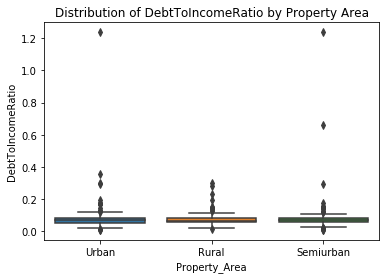

In [9]:

df_anova = df[['Property_Area', 'DebtToIncomeRatio']].dropna()


groups = df_anova.groupby('Property_Area')['DebtToIncomeRatio'].apply(list)


f_stat, p_value = stats.f_oneway(*groups)



print("F-statistic:", f'{f_stat:.3f}')
print("p-value:", f'{p_value:.3f}')
if p_value < 0.05:
    print("Result: Significant difference in mean DebtToIncomeRatio between property_area groups.")
else:
    print("Result: No significant difference in mean DebtToIncomeRatio between property_area groups.")


sns.boxplot(x='Property_Area', y='DebtToIncomeRatio', data=df_anova)
plt.title("Distribution of DebtToIncomeRatio by Property Area")
plt.show()

